In [1]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
import statsmodels.api as sm

## Import Data and Processing Data

In [2]:
raw = pd.read_csv('data_project4.csv')

In [3]:
raw['month'] = pd.to_datetime(raw['month'],format='%Y%m').dt.to_period('M')

In [4]:
A = raw.iloc[:203,1:39].describe().T  # initial train-test split: 203 months vs 192 months
A['sharpe'] = A['mean']/A['std']
top_factors=A.nlargest(5,['sharpe'])  
top_factors.drop('AstAdjChg1YFCF', axis=0, inplace=True)
top_factors

,count,mean,std,min,25%,50%,75%,max,sharpe
FCFP,203.0,0.007872,0.024076,-0.061155,-0.005944,0.007509,0.021760,0.076155,0.326951
CapAcqRatio,203.0,0.007897,0.026166,-0.083546,-0.006113,0.007937,0.023079,0.077692,0.301803
PM5D,203.0,0.009184,0.034587,-0.109636,-0.009165,0.007170,0.026709,0.168481,0.265533
HL1M,203.0,0.009435,0.037839,-0.092548,-0.010269,0.008235,0.023928,0.227777,0.249340


In [5]:
factor_data=raw[['FCFP','HL1M','PM5D','CapAcqRatio']]
factor_data

,FCFP,HL1M,PM5D,CapAcqRatio
0,0.018987,0.009496,0.006498,0.024939
1,0.041034,0.008235,0.000457,0.025917
2,-0.034440,0.038929,0.018280,0.012059
3,-0.026602,-0.020814,-0.016522,0.034101
4,-0.061155,0.016565,0.005967,0.033546
...,...,...,...,...
391,-0.037417,0.024938,-0.029144,0.002678
392,0.025771,0.043167,-0.005244,-0.014819
393,0.014659,0.015524,0.016567,0.013169
394,0.031846,-0.016061,-0.019000,0.036827


In [6]:
tgt_ret_data=factor_data.shift(-1) #shift all the factor return one unit up

In [7]:
# add labels based on tgt_ret, label 1 if tgt_ret is positive; label -1 if tgt_ret is negative
def add_label(col):
    tgt_label = np.full(len(col), np.nan)
    for i in range(len(col)):
        if col[i]>0:
            tgt_label[i]=1
        else:
            tgt_label[i]=-1
    return tgt_label

In [8]:
# pass each column to add_label function
tgt_label_data=tgt_ret_data.apply(add_label, axis=0)
tgt = pd.concat([factor_data,tgt_ret_data, tgt_label_data], axis=1, sort=False)
column_names=['FCFP_tgt_ret','HL1M_tgt_ret','PM5D_tgt_ret','CapAcqRatio_tgt_ret','FCFP_tgt_label','HL1M_tgt_label',
                'PM5D_tgt_label','CapAcqRatio_tgt_label']

tgt.columns=tgt.columns[:4].tolist()+column_names

tgt=tgt.dropna() #drop NAN in the last month caused by shifting
tgt

,FCFP,HL1M,PM5D,CapAcqRatio,FCFP_tgt_ret,HL1M_tgt_ret,PM5D_tgt_ret,CapAcqRatio_tgt_ret,FCFP_tgt_label,HL1M_tgt_label,PM5D_tgt_label,CapAcqRatio_tgt_label
0,0.018987,0.009496,0.006498,0.024939,0.041034,0.008235,0.000457,0.025917,1.0,1.0,1.0,1.0
1,0.041034,0.008235,0.000457,0.025917,-0.034440,0.038929,0.018280,0.012059,-1.0,1.0,1.0,1.0
2,-0.034440,0.038929,0.018280,0.012059,-0.026602,-0.020814,-0.016522,0.034101,-1.0,-1.0,-1.0,1.0
3,-0.026602,-0.020814,-0.016522,0.034101,-0.061155,0.016565,0.005967,0.033546,-1.0,1.0,1.0,1.0
4,-0.061155,0.016565,0.005967,0.033546,0.005321,0.020937,0.016832,-0.041510,1.0,1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.015950,0.015925,-0.006331,0.015429,-0.037417,0.024938,-0.029144,0.002678,-1.0,1.0,-1.0,1.0
391,-0.037417,0.024938,-0.029144,0.002678,0.025771,0.043167,-0.005244,-0.014819,1.0,1.0,-1.0,-1.0
392,0.025771,0.043167,-0.005244,-0.014819,0.014659,0.015524,0.016567,0.013169,1.0,1.0,1.0,1.0
393,0.014659,0.015524,0.016567,0.013169,0.031846,-0.016061,-0.019000,0.036827,1.0,-1.0,-1.0,1.0


In [9]:
# Extract all features from raw dataframe

from numpy import inf
factor_features=raw.iloc[:,39:]
factor_features.drop(factor_features.tail(1).index,inplace=True)
factor_features[factor_features==inf]=0
factor_features.fillna(0,inplace=True)

# Normalize all in-sample features and drop the last row to match the lenght of target lables for all factors
nmlz_features=(factor_features[:203]-factor_features[:203].mean())/factor_features[:203].std()
nmlz_features.drop(nmlz_features.tail(1).index,inplace=True)
nmlz_features[nmlz_features==inf]=0 # fill inf with 0
nmlz_features.fillna(0,inplace=True) # fill na with 0

In [10]:
# list all factor names in order to change label of index
index_names=[['FCFP'],['HL1M'],['PM5D'],['CapAcqRatio']]
col_list=list(nmlz_features.columns)

# run regularized logistic regression to check if each feature is relavant in predicting each factor return
def Lasso_Check_Coefficients(tgt_label,indexnames):
    lgstc_reg =  LR(penalty='l1',solver='liblinear',max_iter=200,random_state=0)
    lgstc_reg.fit(nmlz_features, tgt_label)
    df=pd.DataFrame(lgstc_reg.coef_)
    df.index=indexnames
    df.columns=col_list
    df.columns.name='Coefficients'
    df=df.T
    df=df[~(df==0).all(axis=1)]
    return df

In [11]:
FCFP_coef=Lasso_Check_Coefficients(tgt.iloc[:202,8],index_names[0])
FCFP_features=factor_features[list(FCFP_coef.index)]
FCFP_features

,IPNCONGD,IPNMAT,IPB51222S,IPFUELS,CUMFNS,UEMPLT5,UEMP15OV,UEMP27OV,CLAIMSx,CES1021000001,...,TOTRESNS,COMPAPFFx,TB3SMFFM,EXSZUSx,EXUSUKx,WPSID61,PPICMM,CPIAPPSL,CUSR0000SAD,UMCSENTx
0,81.5010,91.2727,67.0751,67.2816,78.9086,3390,2168,1140,345600,675.9,...,59.646,-0.59,-1.00,1.5616,1.5054,99.0,96.9,108.000,106.900,90.4
1,82.4476,92.2381,68.6368,67.0663,79.8874,3323,2117,1113,348750,674.6,...,57.035,-0.05,-0.51,1.5403,1.5280,99.8,95.9,108.600,106.700,90.2
2,82.8793,92.1139,69.2807,68.3022,79.7239,3386,2070,1121,333250,675.8,...,57.057,0.03,-0.54,1.5391,1.5923,99.9,98.1,109.200,107.100,90.8
3,82.9342,93.1819,70.3967,69.2721,79.9718,3162,2091,1079,336250,678.6,...,59.407,0.08,-0.73,1.4959,1.6313,100.3,98.7,109.800,107.700,92.8
4,83.6119,93.8771,70.2696,69.6353,80.3319,3315,2104,1112,331000,681.6,...,58.302,0.08,-1.19,1.4705,1.6666,100.8,104.2,110.300,107.900,91.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,101.2856,101.8347,107.5018,109.9301,75.3248,2222,2079,1170,213750,685.6,...,1578.615,-0.18,-0.30,0.9880,1.2461,197.6,188.1,124.674,104.939,98.4
391,101.2249,103.3819,105.8295,111.1313,75.6867,2218,2082,1251,216200,679.0,...,1586.844,-0.07,-0.17,0.9787,1.2160,196.6,187.2,124.783,105.043,89.8
392,101.1779,103.5483,108.3731,108.8532,75.1094,1869,2124,1318,213000,679.8,...,1504.805,-0.01,-0.16,0.9906,1.2369,196.4,189.8,124.450,104.941,93.2
393,101.9142,103.2705,112.2083,109.0647,74.6017,1978,2144,1259,215000,680.8,...,1547.136,0.05,-0.18,0.9930,1.2657,196.9,186.3,122.381,104.908,95.5


In [12]:
HL1M_coef=Lasso_Check_Coefficients(tgt.iloc[:202,9],index_names[1])
HL1M_features=factor_features[list(HL1M_coef.index)]
HL1M_features

,IPB51222S,UEMPLT5,UEMP5TO14,CLAIMSx,CES0600000007,HOUSTMW,HOUSTS,HOUSTW,PERMITS,PERMITW,...,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CUSR0000SAD,VXOCLSx
0,67.0751,3390,2399,345600,40.4,423,609,440,570,483,...,1.5616,154.8295,1.5054,1.3606,89.3,18.656,96.9,108.000,106.900,20.7666
1,68.6368,3323,2415,348750,40.7,360,661,501,603,409,...,1.5403,153.4068,1.5280,1.3340,90.2,17.726,95.9,108.600,106.700,23.4463
2,69.2807,3386,2393,333250,40.4,333,628,473,625,443,...,1.5391,151.4332,1.5923,1.3194,90.5,18.305,98.1,109.200,107.100,21.8372
3,70.3967,3162,2236,336250,40.2,290,662,404,604,412,...,1.4959,142.8986,1.6313,1.3192,92.5,18.643,98.7,109.800,107.700,26.8814
4,70.2696,3315,2100,331000,40.5,306,629,391,576,379,...,1.4705,140.4790,1.6666,1.3411,93.8,19.415,104.2,110.300,107.900,25.4115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,107.5018,2222,1795,213750,41.0,174,624,318,696,370,...,0.9880,108.2864,1.2461,1.3105,183.3,57.350,188.1,124.674,104.939,12.9851
391,105.8295,2218,1746,216200,41.1,190,718,301,773,344,...,0.9787,106.1886,1.2160,1.3273,180.4,54.810,187.2,124.783,105.043,21.0968
392,108.3731,1869,1778,213000,41.2,158,693,308,756,373,...,0.9906,107.5400,1.2369,1.3241,180.4,56.950,189.8,124.450,104.941,16.3081
393,112.2083,1978,1747,215000,41.0,178,691,355,790,375,...,0.9930,108.1368,1.2657,1.3189,181.0,53.960,186.3,122.381,104.908,15.9863


In [13]:
PM5D_coef=Lasso_Check_Coefficients(tgt.iloc[:202,10],index_names[2])
PM5D_features=factor_features[list(PM5D_coef.index)]
PM5D_features

,IPNCONGD,IPB51222S,HWI,UEMPMEAN,UEMP15T26,CLAIMSx,AWOTMAN,HOUSTMW,HOUSTS,PERMITNE,...,T1YFFM,AAAFFM,EXJPUSx,EXUSUKx,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CUSR0000SAD,UMCSENTx
0,81.5010,67.0751,4257,14.9,1028,345600,3.5,423,609,286,...,-0.65,1.93,154.8295,1.5054,89.3,18.656,96.9,108.000,106.900,90.4
1,82.4476,68.6368,4513,14.7,1004,348750,3.7,360,661,306,...,-0.14,2.28,153.4068,1.5280,90.2,17.726,95.9,108.600,106.700,90.2
2,82.8793,69.2807,4703,14.9,949,333250,3.7,333,628,317,...,-0.10,2.23,151.4332,1.5923,90.5,18.305,98.1,109.200,107.100,90.8
3,82.9342,70.3967,4665,14.8,1012,336250,3.3,290,662,287,...,0.13,2.48,142.8986,1.6313,92.5,18.643,98.7,109.800,107.700,92.8
4,83.6119,70.2696,4794,14.9,992,331000,3.7,306,629,267,...,0.15,2.48,140.4790,1.6666,93.8,19.415,104.2,110.300,107.900,91.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,101.2856,107.5018,7236,19.7,909,213750,4.2,174,624,131,...,-0.44,0.89,108.2864,1.2461,183.3,57.350,188.1,124.674,104.939,98.4
391,101.2249,105.8295,7166,22.1,831,216200,4.2,190,718,164,...,-0.35,0.86,106.1886,1.2160,180.4,54.810,187.2,124.783,105.043,89.8
392,101.1779,108.3731,7046,21.7,806,213000,4.2,158,693,131,...,-0.25,0.98,107.5400,1.2369,180.4,56.950,189.8,124.450,104.941,93.2
393,101.9142,112.2083,7309,21.6,884,215000,4.1,178,691,155,...,-0.22,1.18,108.1368,1.2657,181.0,53.960,186.3,122.381,104.908,95.5


In [14]:
CapAcqRatio_coef=Lasso_Check_Coefficients(tgt.iloc[:202,11],index_names[3])
CapAcqRatio_features=factor_features[list(CapAcqRatio_coef.index)]
CapAcqRatio_features

,IPB51222S,IPFUELS,CUMFNS,UEMPMEAN,UEMP5TO14,UEMP15T26,CLAIMSx,CES1021000001,DMANEMP,CES0600000007,...,T1YFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSID62,OILPRICEx,PPICMM,UMCSENTx,VXOCLSx
0,67.0751,67.2816,78.9086,14.9,2399,1028,345600,675.9,10688,40.4,...,-0.65,1.5616,154.8295,1.5054,1.3606,89.3,18.656,96.9,90.4,20.7666
1,68.6368,67.0663,79.8874,14.7,2415,1004,348750,674.6,10714,40.7,...,-0.14,1.5403,153.4068,1.5280,1.3340,90.2,17.726,95.9,90.2,23.4463
2,69.2807,68.3022,79.7239,14.9,2393,949,333250,675.8,10713,40.4,...,-0.10,1.5391,151.4332,1.5923,1.3194,90.5,18.305,98.1,90.8,21.8372
3,70.3967,69.2721,79.9718,14.8,2236,1012,336250,678.6,10715,40.2,...,0.13,1.4959,142.8986,1.6313,1.3192,92.5,18.643,98.7,92.8,26.8814
4,70.2696,69.6353,80.3319,14.9,2100,992,331000,681.6,10724,40.5,...,0.15,1.4705,140.4790,1.6666,1.3411,93.8,19.415,104.2,91.1,25.4115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,107.5018,109.9301,75.3248,19.7,1795,909,213750,685.6,8067,41.0,...,-0.44,0.9880,108.2864,1.2461,1.3105,183.3,57.350,188.1,98.4,12.9851
391,105.8295,111.1313,75.6867,22.1,1746,831,216200,679.0,8066,41.1,...,-0.35,0.9787,106.1886,1.2160,1.3273,180.4,54.810,187.2,89.8,21.0968
392,108.3731,108.8532,75.1094,21.7,1778,806,213000,679.8,8066,41.2,...,-0.25,0.9906,107.5400,1.2369,1.3241,180.4,56.950,189.8,93.2,16.3081
393,112.2083,109.0647,74.6017,21.6,1747,884,215000,680.8,8019,41.0,...,-0.22,0.9930,108.1368,1.2657,1.3189,181.0,53.960,186.3,95.5,15.9863


In [15]:
FCFP=tgt['FCFP_tgt_label']
HL1M=tgt['HL1M_tgt_label']
PM5D=tgt['PM5D_tgt_label']
CapAcqRatio=tgt['CapAcqRatio_tgt_label']

## Classfier Implementation

In [16]:
grid={'solver':['svd', 'lsqr', 'eigen']}

In [17]:
win = 6  # size of moving window
lst1 = ['LDA', FCFP, FCFP_features, grid, 203, win]
lst2 = ['LDA', HL1M, HL1M_features, grid, 203, win]
lst3 = ['LDA', PM5D, PM5D_features, grid, 203, win]
lst4 = ['LDA', CapAcqRatio, CapAcqRatio_features, grid, 203, win]

lst5 = ['LR', FCFP, FCFP_features, 203, win]
lst6 = ['LR', HL1M, HL1M_features, 203, win]
lst7 = ['LR', PM5D, PM5D_features, 203, win]
lst8 = ['LR', CapAcqRatio, CapAcqRatio_features, 203, win]

lsts = [lst1,lst2,lst3,lst4,lst5,lst6,lst7,lst8]

In [18]:
def ML(lst):

    Y = np.asarray(lst[1]) #convert the excess return column in df to an array
    X = np.asarray(lst[2])
    Y_Pred_list = []
    Score = []
    Winner_score=[]
    Loser_score=[]
    for i in range(lst[-2],395,lst[-1]):  # initial split is 203:192; then we do an expanding window of 6 month
        Y1 = Y[0:i]
        X0 = X[0:i,:]
        X1 = (X0-X0.mean())/X0.std()
        if lst[0]=='LDA':        
            clf = LDA(solver='svd',shrinkage=None)
            clf.fit(X1, Y1)
            grid = GridSearchCV(clf, lst[3], cv=3)  # hyper tuning parameter search by cross-validation
            grid.fit(X1, Y1)
            best_clf = grid.best_estimator_
            Xn = (X[i:i+lst[-1],:]-X[i:i+lst[-1],:].mean())/X[i:i+lst[-1],:].std() # We normalize the 6 month testing features
            y_pred = best_clf.predict(Xn)
            Y_Pred_list.append(y_pred)
            Score.append(metrics.accuracy_score(Y[i:i+lst[-1]], y_pred))
            
        else:
            clf=LR(penalty='l1',solver='liblinear',max_iter=300,random_state=0,class_weight='balanced')
            clf.fit(X1, Y1)
            Xn = (X[i:i+lst[-1],:]-X[i:i+lst[-1],:].mean())/X[i:i+lst[-1],:].std()
            y_pred = clf.predict(Xn)       
            Y_Pred_list.append(y_pred)
            Score.append(metrics.accuracy_score(Y[i:i+lst[-1]], y_pred))

    Y_Pred_list = np.array(Y_Pred_list).flatten()
    Score = np.array(Score).flatten()
    os_score=metrics.accuracy_score(Y[lst[-2]:], Y_Pred_list)  # metrics.accuracy_score(FCFP[203:], ypred)
    cm_overall = confusion_matrix(Y[lst[-2]:], Y_Pred_list, normalize = 'true')
    return [Y_Pred_list, Score, os_score,cm_overall]

In [19]:
lda_acc = np.array([ML(lst1)[2],ML(lst2)[2],ML(lst3)[2],ML(lst4)[2]])
lr_acc = np.array([ML(lst5)[2],ML(lst6)[2],ML(lst7)[2],ML(lst8)[2]])
Accuracy_table=pd.DataFrame(lda_acc)
Accuracy_table['LR Accuracy']=lr_acc
Accuracy_table.columns = ['LDA Accuracy Score', 'LR Accuracy Score']
Accuracy_table['Factors']=['FCFP','HL1M','PM5D','CapAcqRatio']
Accuracy_table.set_index('Factors',inplace=True)
Accuracy_table

,LDA Accuracy Score,LR Accuracy Score
Factors,,
FCFP,0.520833,0.494792
HL1M,0.526042,0.442708
PM5D,0.515625,0.479167
CapAcqRatio,0.572917,0.432292


In [20]:
# Calculate prediction volaility in terms of overall accuracy score

std_index=['FCFP','HL1M','PM5D','CapAcqRatio']
LDA_std=[ML(lst1)[1].std(),ML(lst2)[1].std(),ML(lst3)[1].std(),ML(lst4)[1].std()]
LR_std=[ML(lst5)[1].std(),ML(lst6)[1].std(),ML(lst7)[1].std(),ML(lst8)[1].std()]
LDA_pred_std=pd.DataFrame({'LDA Prediction Volatility':LDA_std},index=std_index)
LR_pred_std=pd.DataFrame({'LR Prediction Volatility':LR_std},index=std_index)

In [21]:
LDA_pred_std

,LDA Prediction Volatility
FCFP,0.219493
HL1M,0.200301
PM5D,0.188006
CapAcqRatio,0.220233


In [22]:
LR_pred_std

,LR Prediction Volatility
FCFP,0.241107
HL1M,0.193691
PM5D,0.185171
CapAcqRatio,0.223837


In [23]:
tick_labels=raw.loc[203::6,'month'].drop(203).values
str_tick_labels=list(map(str,tick_labels))
tickvalues=range(0,len(str_tick_labels))
graph_title=['LDA Accuracy Score with 6-Montth Expanding Window','LR Accuracy Score with 6-Month Expanding Window']

In [24]:
def plot(lst_a,lst_b,lst_c,lst_d,graphtitle):
    plt.figure(figsize=(15,5))
    plt.xticks(ticks=tickvalues, labels=str_tick_labels, rotation='vertical')
    plt.plot(ML(lst_a)[1],'orange', label="FCFP")
    plt.plot(ML(lst_b)[1],'blue', label="HL1M")
    plt.plot(ML(lst_c)[1],'yellow', label="PM5D")
    plt.plot(ML(lst_d)[1],'green', label="CapAcqRatio")
    plt.xlabel('Time')
    plt.ylabel('Accuracy Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title(graphtitle)
    plt.show()

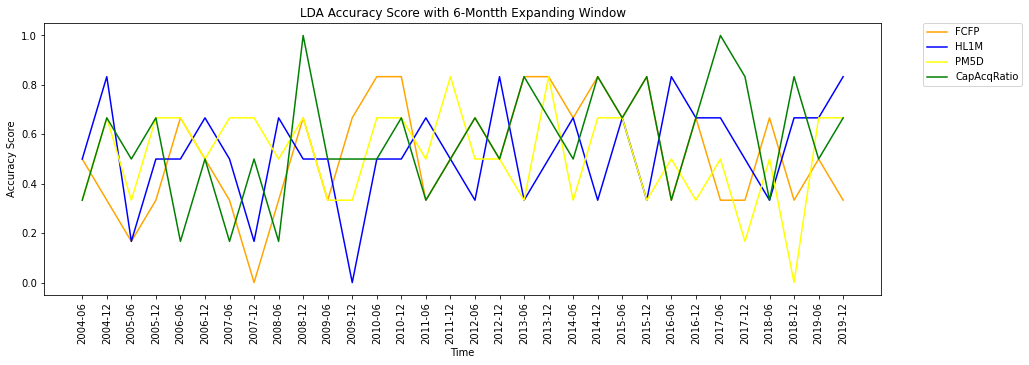

In [25]:
plot(lst1, lst2, lst3, lst4, graph_title[0])

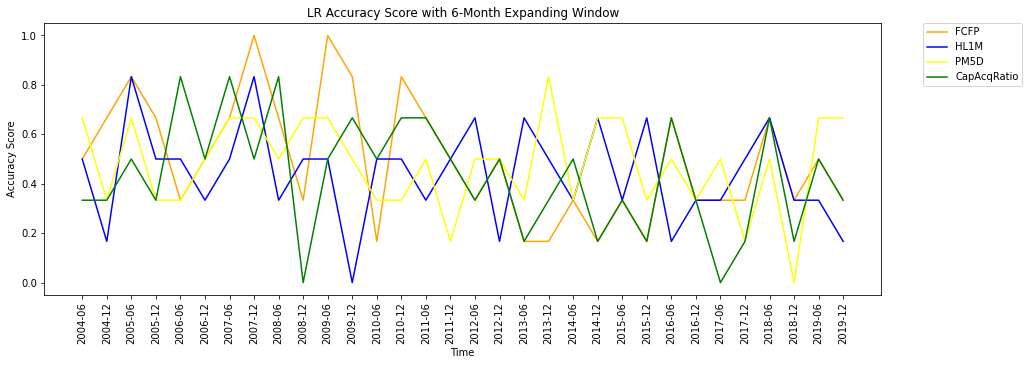

In [26]:
plot(lst5, lst6, lst7, lst8, graph_title[1])

## Portfolio Construction

In [27]:
FCFP_predict=ML(lst1)[0] # Period 203-395
HL1M_predict=ML(lst2)[0]
PM5D_predict=ML(lst3)[0]
CapAcqRatio_predict=ML(lst4)[0]
wl = 0.1  # maximum short weight; if wl=0, long-only portfolio

In [28]:
y_predict_data = {'FCFP_predict': FCFP_predict, 'HL1M_predict': HL1M_predict,'PM5D_predict'
                 :PM5D_predict,'CapAcqRatio_predict':CapAcqRatio_predict}

In [29]:
predict_labels= pd.DataFrame(data=y_predict_data)

In [30]:
predict_labels['1_count']=predict_labels[predict_labels==1].sum(axis=1)
predict_labels['-1_count']=predict_labels[predict_labels==-1].sum(axis=1)

In [31]:
predict_labels

,FCFP_predict,HL1M_predict,PM5D_predict,CapAcqRatio_predict,1_count,-1_count
0,-1.0,1.0,1.0,1.0,3.0,-1.0
1,-1.0,1.0,1.0,1.0,3.0,-1.0
2,-1.0,1.0,1.0,1.0,3.0,-1.0
3,-1.0,1.0,1.0,1.0,3.0,-1.0
4,-1.0,1.0,1.0,1.0,3.0,-1.0
...,...,...,...,...,...,...
187,-1.0,1.0,-1.0,1.0,2.0,-2.0
188,-1.0,1.0,-1.0,1.0,2.0,-2.0
189,-1.0,1.0,-1.0,1.0,2.0,-2.0
190,-1.0,1.0,-1.0,1.0,2.0,-2.0


In [32]:
def assign_weight(col):
    weights = np.full(len(col), np.nan)
    for i in range(len(col)):
        if col[i]==1:
            weights[i]=(1+wl)/predict_labels['1_count'][i]
        else:
            weights[i]=wl/predict_labels['-1_count'][i]
    return weights

In [33]:
factor_weights=predict_labels.iloc[:,0:4].apply(assign_weight,axis=0).round(3)
factor_weights

,FCFP_predict,HL1M_predict,PM5D_predict,CapAcqRatio_predict
0,-0.10,0.367,0.367,0.367
1,-0.10,0.367,0.367,0.367
2,-0.10,0.367,0.367,0.367
3,-0.10,0.367,0.367,0.367
4,-0.10,0.367,0.367,0.367
...,...,...,...,...
187,-0.05,0.550,-0.050,0.550
188,-0.05,0.550,-0.050,0.550
189,-0.05,0.550,-0.050,0.550
190,-0.05,0.550,-0.050,0.550


In [34]:
fac = tgt[['FCFP_tgt_ret','HL1M_tgt_ret', 'PM5D_tgt_ret', 'CapAcqRatio_tgt_ret']]
fac_ret=fac.iloc[203:,]

In [35]:
df=pd.DataFrame((factor_weights.values)*(fac_ret.values))

In [36]:
rf=(pd.DataFrame(raw.iloc[203:,]['TB3MS'])/100)/12  # use three-month treasury bill rate as Rf
rf.drop(rf.head(1).index,inplace=True)

In [37]:
portfolio_ret=pd.DataFrame(df.sum(axis=1))

In [38]:
portfolio_ret['1_count']=predict_labels['1_count']
portfolio_ret['-1_count']=predict_labels['-1_count']
list_all_winners=portfolio_ret[portfolio_ret['1_count'] == 4].index.tolist() 
list_all_losers=portfolio_ret[portfolio_ret['-1_count'] == -4].index.tolist()
for i in list_all_winners:
    portfolio_ret.iloc[i,:]=0.25*(fac_ret.iloc[i,:].sum())
for i in list_all_losers:
    portfolio_ret.loc[i,:]= (1+wl)*(rf.iloc[i])-(wl/4)*(fac_ret.iloc[i,:].sum())
portfolio_ret.drop(['1_count','-1_count'],axis=1,inplace=True)

In [39]:
portfolio_ret.columns=['Portfolio Return']
portfolio_ret

,Portfolio Return
0,-0.005532
1,-0.009974
2,-0.013373
3,0.004293
4,0.030129
...,...
187,0.018516
188,0.014565
189,0.014220
190,0.010779


## Portfolio Evaluation

### Portfolio Stats

In [40]:
stats=portfolio_ret.describe()
stats.columns=['Portfolio Return Stats']
stats

,Portfolio Return Stats
count,186.000000
mean,0.004542
std,0.021425
min,-0.065500
25%,-0.009073
50%,0.004249
75%,0.016395
max,0.113403


### Sharpe Ratio

In [41]:
ret_mean=float(portfolio_ret.mean())
rf_mean=float(rf.mean())
ret_std=float(portfolio_ret.std())
sharpe_ratio=(ret_mean-rf_mean)/ret_std
sr=pd.DataFrame({'portfolio mean':[ret_mean],'rf mean':[rf_mean],'sharpe ratio':[sharpe_ratio]})
sr

,portfolio mean,rf mean,sharpe ratio
0,0.004542,0.001082,0.161472


### Alpha

In [42]:
# Calculate out of sample market risk premium
mkt=pd.DataFrame(raw.loc[203:,'S&P 500'].pct_change())
mkt.drop(mkt.head(1).index,inplace=True)
mktrf=pd.DataFrame(mkt.values-rf.values)
mktrf.columns=['mktrf']

In [43]:
# Famma-French three factor
famma_fr=raw.loc[204:,['BP','LogMktCap']]
famma_fr.insert(loc=0,column='mktrf',value=mktrf.values) # insert marke risk premium to famma_fr dataframe

In [44]:
x_mkt=np.asarray(mktrf)
x_mkt=sm.add_constant(x_mkt)

x_famma_fr=np.asarray(famma_fr)
x_famma_fr=sm.add_constant(x_famma_fr)

In [45]:
mkt_index_list=['Alpha','mktrf']
famma_fr_index_list=['Alpha','mktrf','BP','LogMktCap']

In [46]:
# run OLS regression to calculate alpha and coefficients
def alpha_test(predictors,indexlist):
    reg=sm.OLS(portfolio_ret,predictors,missing='drop').fit()
    performance=pd.DataFrame({'coefficients':reg.params,'t_test':reg.tvalues})
    performance.index=indexlist
    return performance

In [47]:
# alpha compared with mrp
alpha_test(x_mkt,mkt_index_list)

,coefficients,t_test
Alpha,0.004375,2.749197
mktrf,0.033677,0.698339


In [48]:
# alpha compared with famma french three factors
alpha_test(x_famma_fr,famma_fr_index_list)

,coefficients,t_test
Alpha,0.004654,2.973041
mktrf,-0.042255,-0.827377
BP,0.038907,0.577939
LogMktCap,0.175485,2.279840
